# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

# Problem Set 13: Sampling techniques and Monte Carlo simulation

## 13.1: Rejection method
### a) Determine normalization $p_0$

Integral:  1.0


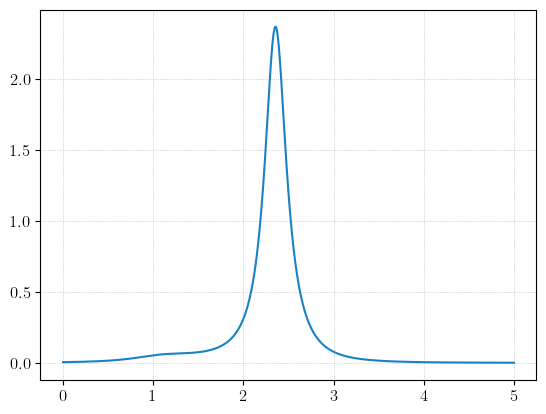

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('light')

def p(x,p0):
    return p0/((x-2)**4 + np.sin(x-3)**8)

# Define symbols
x = np.linspace(0, 5, 1000)
p_analytic = p(x, 1)
intp = np.trapz(p_analytic, x)
p_analytic = p_analytic/intp

print("Integral: ", np.trapz(p_analytic, x))

plt.plot(x, p_analytic)

# b) Use Rejection method with uniform parent distribution

In [2]:
def rejection_method(p, p0, N):
    x = np.random.uniform(0, 5, N)
    y = np.random.uniform(0, 1, N)
    p_sampled = p(x, p0)
    x_accepted = x[np.where(y <= 0.1*p_sampled)]
    return x_accepted
    

In [3]:
x_accepted = rejection_method(p, 1/intp, 10**6)

print("Rejection Rate: ", np.round(100*(1 - len(x_accepted)/10**6), 2), "%")

Rejection Rate:  98.0 %


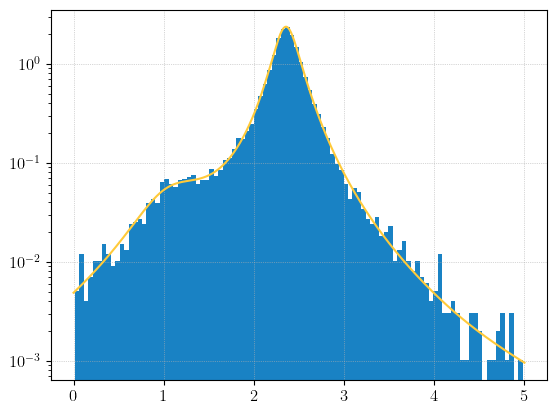

In [4]:
plt.hist(x_accepted, bins=100, density=True)
plt.plot(x, p_analytic)
plt.yscale("log")
plt.show()

# c) Consider a function piecewise linear function $f(x)$

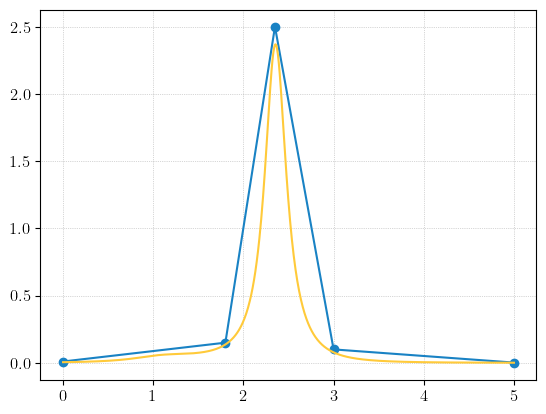

In [5]:
points = np.array([[0,0.01], [1.8,0.15], [2.35, 2.5], [3.0, 0.1], [5.0, 0.002]])

# Interpolate
f = lambda x: np.interp(x, points[:,0], points[:,1])

intp_linear = np.trapz(f(x), x)
plt.plot(points[:,0], points[:,1], "-o")
plt.plot(x, p(x, 1/intp))

To sample from the given piecewise linear function we can use the inverse sampling method. This could be done analytically for this simple function but i was too stupid to do it so i used this numercial hack

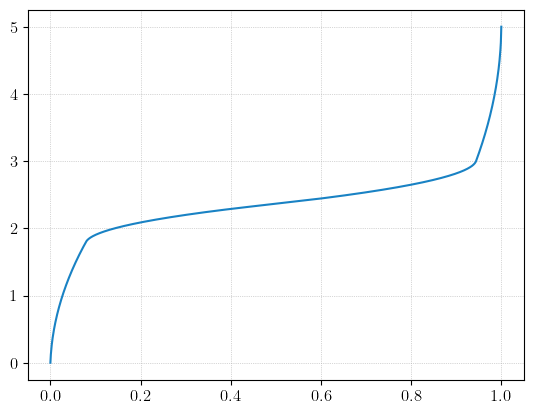

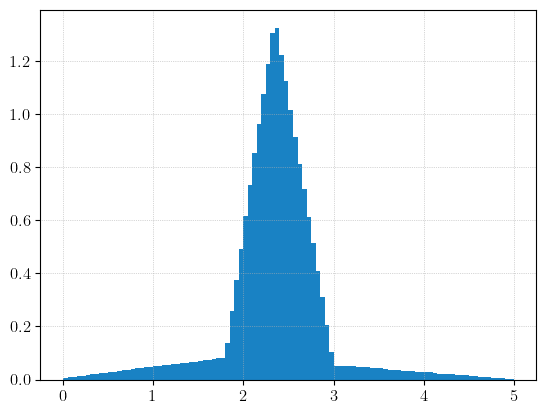

In [6]:
def cdf(f,x):
    """Calculate the CDF of a function f.

    Args:
        f function
        x linear space

    Returns:
        inverse CDF
    """
    pdf = f(x)/np.trapz(f(x), x)
    cdf = np.cumsum(pdf)
    return cdf

# Calculate CDF
xlin = np.linspace(0,5,10000)
cdf_lin = cdf(f, xlin)
cdf_lin /= np.max(cdf_lin)

# Create fake inverse CDF function by interpolation of CDF with x and y axis swapped
inv_cdf_fun = lambda x: np.interp(x, cdf_lin, xlin)

# Plot inverse CDF
xnew = np.linspace(0,1,1000)
plt.plot(xnew, inv_cdf_fun(xnew))
plt.show()

# Sample from inverse CDF
samples = inv_cdf_fun(np.random.uniform(0,1,10**6))
plt.hist(samples, bins=100, density=True)
plt.show()

In [7]:
def rejection_method_new(p, p0, N):
    # 1. Generate x from f(x)
    x = inv_cdf_fun(np.random.uniform(0, 1, N))
    # 2. Generate y from uniform distribution with bounds 0 <= y < C*f(x)
    y = np.random.uniform(0, f(x), N)
    # 3. + 4. If y <= p(x), accept x
    p_sampled = p(x, p0)
    mask = np.where(y <= p_sampled)
    x_accepted = x[mask]
    y_accepted = y[mask]
    return x_accepted, y_accepted,x,y

In [8]:
x_accepted,y_accepted, x_rejected,y_rejected = rejection_method_new(p, 1/intp, 10**6)

print("Rejection Rate: ", np.round(100*(1 - len(x_accepted)/10**6), 2), "%")

Rejection Rate:  45.11 %


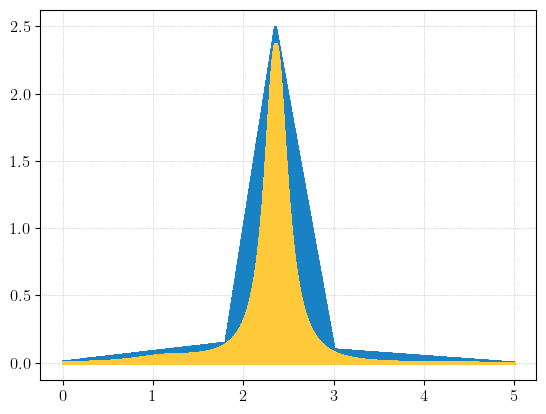

In [9]:
plt.plot(x_rejected,y_rejected, "o", markersize=1)
plt.plot(x_accepted, y_accepted, "o", markersize=1)

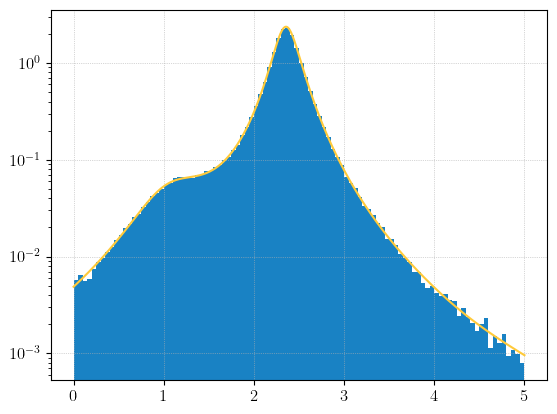

In [10]:
plt.hist(x_accepted, bins=100, density=True)
plt.plot(x, p_analytic)
plt.yscale("log")
plt.show()

# 13.2 Sampling a given distribution with a Monte Carlo Markov chain

Integral:  1.0


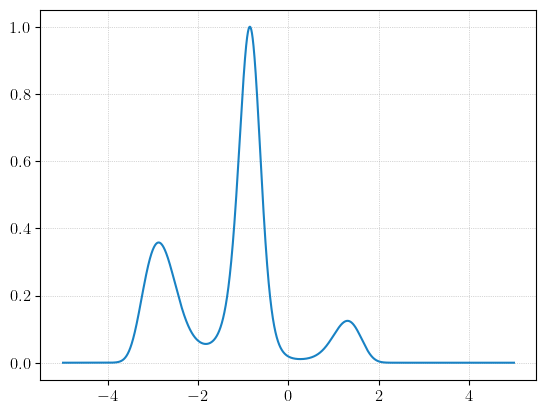

In [23]:
def p(x, p0):
    return p0*np.exp(-(x+2*np.cos(x)**2)**2)

x = np.linspace(-5, 5, 10000)
p_analytic = p(x, 1)
intp = np.trapz(p_analytic, x)
p_analytic = p_analytic/intp

print("Integral: ", np.trapz(p_analytic, x))

plt.plot(x, p(x,1))

In [29]:

def MCMC(p, N, x0):
    """
    Monte Carlo Markov Chain (MCMC) using the Metropolis-Hastings algorithm.

    Args:
        p (function): The target distribution to sample from.
        N (int): Number of samples to generate.
        x0 (float): Initial state of the chain.
        proposal_std (float): Standard deviation of the proposal distribution.

    Returns:
        samples (list): List of generated samples.
    """
    # a) start with random guess
    samples = [x0]
    x_current = x0

    for _ in range(N):
        # b) Generate a proposal sample
        x_proposed = np.random.uniform(-5,5)

        # Calculate acceptance probability
        acceptance_prob = min(1, p(x_proposed, 1/intp) / p(x_current, 1/intp))

        # c) Accept or reject the proposal sample
        if np.random.uniform() < acceptance_prob:
            x_current = x_proposed
            samples.append(x_current)
        else:
            samples.append(x_current)

    return samples

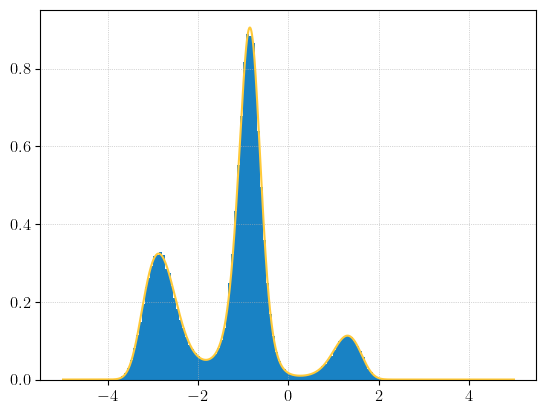

In [30]:
# d) Produce a chain of 10^6 samples
chain = MCMC(p, 10**6, 0.5)

# Make a histogram of the samples in the chain
plt.hist(chain, bins=100, density=True)
plt.plot(x, p(x,1/intp))
plt.show()

In [203]:
distinct_points = len(set(chain))
print("Percentage of distinct points in the chain: {:.2f} %".format(distinct_points/len(chain)))

Percentage of distinct points in the chain: 0.24 %


# 13.3. Monte Carlo simulation of the 2D Ising model

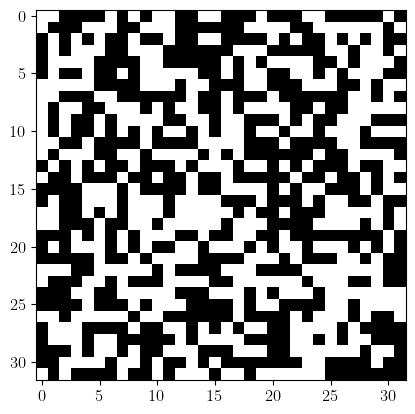

In [206]:
size = 32
N = size**2
lattice = np.random.choice([-1,1], size=(size,size))
betas = [1.6, 1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.1]
plt.imshow(lattice, cmap="gray")
plt.grid(False)

In [212]:
import numpy as np

def gibbs_sampling(i,j, lattice, beta):
    delta_energy = -lattice[i,j]*(lattice[(i+1)%size, j] + lattice[i,(j+1)%size] + lattice[(i-1)%size, j] + lattice[i,(j-1)%size])
    p_sx = 1/(1 + np.exp(-beta*delta_energy))
    if np.random.uniform() < p_sx:
        lattice[i,j] *= -1
    return lattice

def update_red_points(lattice, beta):
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if (i + j) % 2 == 0:  # Red point condition
                lattice = gibbs_sampling(i,j, lattice, beta)
    return lattice

def update_black_points(lattice, beta):
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if (i + j) % 2 != 0:  # Black point condition
                lattice = gibbs_sampling(i,j, lattice, beta)
    return lattice

def ising_model(beta):
    lattice = np.random.choice([-1,1], size=(size,size))
    magnetizations = 0
    
    # a) Thermal equilization
    for _ in range(3000):
        lattice = update_red_points(lattice, beta)
        lattice = update_black_points(lattice, beta)
    
    # b) Sampling magnetization
    for _ in range(1000):
        lattice = update_red_points(lattice, beta)
        lattice = update_black_points(lattice, beta)
        magnetizations = magnetizations + np.sum(lattice)/N
    
    return lattice, magnetizations

# b) Measurements of $M$

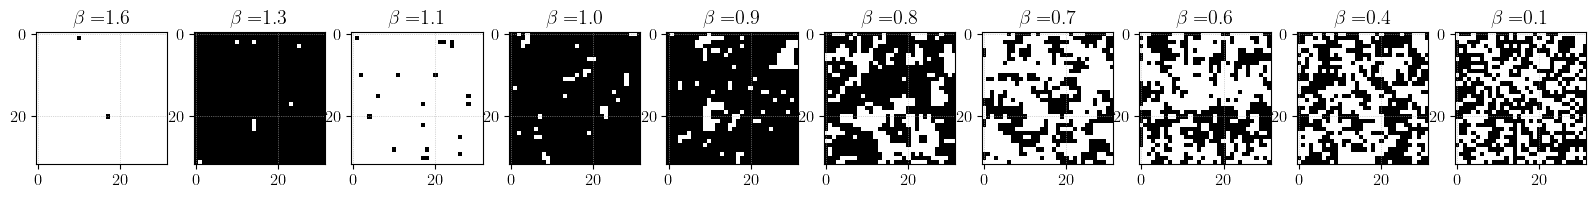

In [213]:
mean_magnetizations = []
size=32
fig,ax = plt.subplots(1,len(betas), figsize=(20,5))

for i,beta in enumerate(betas):
    lattice, magnetizations = ising_model(beta)
    mean_magnetizations.append(np.abs(magnetizations)/1000)
    
    ax[i].imshow(lattice, cmap="gray")
    ax[i].set_title(r"$\beta = $" + str(beta))
    
plt.show()

In [214]:
import pandas as pd

# Create a dictionary with the data
data = {'beta': betas, '<|M|>': mean_magnetizations}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,beta,<|M|>
0,1.6,0.996059
1,1.3,0.983791
2,1.1,0.955129
3,1.0,0.909777
4,0.9,0.798270
5,0.8,0.063898
6,0.7,0.018490
7,0.6,0.000691
8,0.4,0.002926
9,0.1,0.001580


# c) Plot of $\langle|M|\rangle$

In [215]:
import tqdm

size = 16
mean_magnetizations = []
betas = 1/np.linspace(0.625, 10, 64)

for i,beta in tqdm.tqdm(enumerate(betas)):
    lattice, magnetizations = ising_model(beta)
    mean_magnetizations.append(np.abs(magnetizations)/1000)


64it [01:49,  1.72s/it]


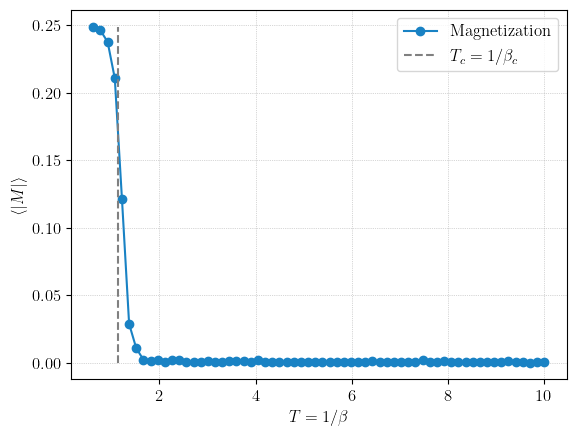

In [225]:
plt.plot(1/np.array(betas), mean_magnetizations, "-o", label="Magnetization")
plt.vlines(1/np.log(1+np.sqrt(2)), 0, np.max(mean_magnetizations), linestyles="dashed", color="gray", label="$T_c=1/\\beta_c$")
plt.xlabel(r"$T=1/\beta$")
plt.ylabel(r"$\langle |M| \rangle$")
plt.legend()